# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve


## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)  #datos de entrenamiento (80% del dataset original)
df_orig.shape

(239, 13)

In [4]:
df_cleaned = df_orig.copy()
feat_train, targ_train = df_orig.drop(["DEATH_EVENT"],axis=1),df_orig["DEATH_EVENT"]
print(feat_train.shape)
print(targ_train.shape)

(239, 12)
(239,)


## Transformaciones necesarias al df

In [5]:
#df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)

df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, CREATININE_PHOSPHOKINASE, EJECTION_FRACTION, PLATELETS, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,50,1
180,40.0,478,30,303000.0,0.9,136,148,0
237,70.0,232,30,173000.0,1.2,132,210,0
280,70.0,2695,40,241000.0,1.0,137,247,0
181,59.0,176,25,221000.0,1.0,136,150,1


In [6]:
print(df_cleaned.shape)  #6 features + target

(239, 8)


In [7]:
#feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.1,random_state=420)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [8]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]
print(feat_train.shape)
print(targ_train.shape)

(239, 7)
(239,)


In [9]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE(random_state=420).fit_resample(feat_train, targ_train)
feat_train.shape

print(np.sum(targ_train==0))
print(np.sum(targ_train==1))

163
76
163
163


## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [10]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [11]:
def aoc_curves (model,feat,targ):
    predicted_p = cross_val_predict(model,feat,targ,cv=10,method="predict_proba")
    fpr, tpr, thres = roc_curve(targ, predicted_p[:,1])
    precisions, recalls, thres = precision_recall_curve(targ, predicted_p[:,1])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recalls, precisions)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,label = "ROC AOC:{:.3f}".format(roc_auc))
    plt.plot([0,1],[0,1],'--k', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recalls,precisions,label = "PR AOC:{:.3f}".format(pr_auc))
    plt.plot([1,0],[0,1],'--k', alpha=0.5)
    plt.ylabel('Precisión')
    plt.xlabel('Recall')
    plt.title('Curva PR')
    plt.legend()

In [12]:
def train_test_curve (model,param,param_range): 
    train__scores, test__scores = validation_curve(model,feat_train,targ_train,param_name=param,param_range=param_range,scoring=score_metric,cv=20)

    train__mean = np.mean(train__scores,axis=1)
    #train__std = np.std(train__scores,axis=1)
    test__mean = np.mean(test__scores,axis=1)
    #test__std = np.std(test__scores,axis=1)
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,2)
    plt.plot(param_range,train__mean,color='blue',marker='o',markersize=5,label='training recall')
    plt.xscale("log")
    plt.plot(param_range,test__mean,color='green',marker='x',markersize=5,label='test recall') 
    plt.xlabel(param)
    plt.ylabel(score_metric)
    plt.legend(loc='upper left')

In [13]:
def plt_eb (model,rmax):
    means,errors = [],[]
    
    for j in range(2,rmax):
        scorings = cross_val_score(model, feat_train, targ_train,cv=j, scoring=score_metric)
        means.append(scorings.mean())
        errors.append(scorings.std())

    plt.figure(figsize=(15,8))
    plt.xlabel("Cantidad de Folds en CV")
    plt.ylabel("Recall Score")
    plt.title("Mean: {:.3f}+/-{:.3f}".format(np.mean(means),np.mean(errors)))
    plt.ylim((0,1.1))
    plt.errorbar(x=range(2,rmax),y=means,yerr=errors,fmt="-o")

In [14]:
def model_setup (model):
    model.fit(feat_train,targ_train)

    scoring = cross_val_score(model, feat_train, targ_train,cv=10, scoring=score_metric)
    print("Cross Validation Score: {:.3f} +/- {:.3f}".format(scoring.mean(),scoring.std()))

    predicted = cross_val_predict(model,feat_train,targ_train,cv=10)
    print(classification_report(targ_train, predicted))
    
    cm = confusion_matrix(targ_train, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

---
---
---

# BASELINE

Cross Validation Score: 0.721 +/- 0.192
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       163
           1       0.76      0.72      0.74       163

    accuracy                           0.75       326
   macro avg       0.75      0.75      0.75       326
weighted avg       0.75      0.75      0.75       326



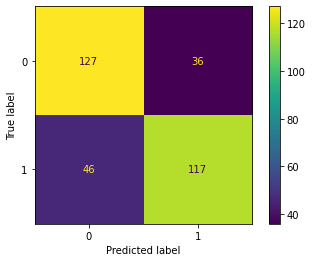

In [15]:
percep1 = Perceptron(fit_intercept=True, max_iter=40000)
model_setup(percep1)

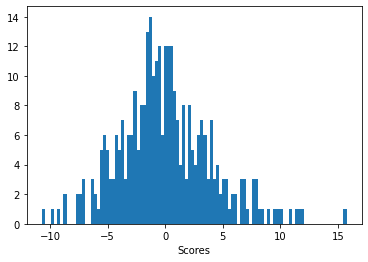

In [59]:
y_scores = cross_val_predict(percep1, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

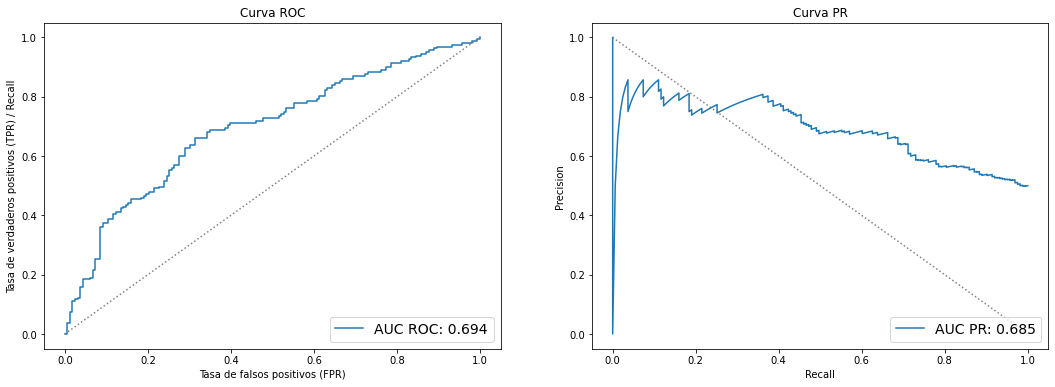

In [63]:
precisions, recalls, thresholds = precision_recall_curve(targ_train, y_scores)
fpr, tpr, thresholds = roc_curve(targ_train, y_scores)

auc_score_PR = auc(recalls, precisions)
auc_score_ROC = auc(fpr,tpr)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(122)
ax.plot(recalls,precisions, label = "AUC PR: {:.3f}".format(auc_score_PR))
ax.plot([0, 1], [1, 0], color='0.5', ls=':')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Curva PR')
ax.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(121)
ax2.plot(fpr, tpr,label = "AUC ROC: {:.3f}".format(auc_score_ROC))
ax2.plot([0, 1], [0, 1], color='0.5', ls=':')
ax2.set_xlabel('Tasa de falsos positivos (FPR)')
ax2.set_ylabel('Tasa de verdaderos positivos (TPR) / Recall')
ax2.set_title('Curva ROC')
ax2.legend(loc='lower right', fontsize=14)

Cross Validation Score: 0.731 +/- 0.104
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       163
           1       0.75      0.73      0.74       163

    accuracy                           0.74       326
   macro avg       0.74      0.74      0.74       326
weighted avg       0.74      0.74      0.74       326



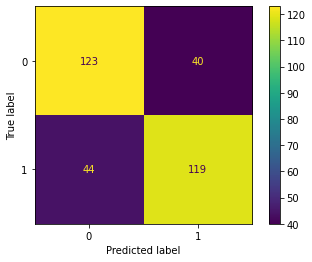

In [16]:
percep2 = Perceptron(max_iter=40000,penalty="l2",random_state=420,alpha=0.0012689610031679235,eta0=0.041753189365604)
model_setup(percep2)

In [17]:
hyperparam = {"eta0":np.logspace(-2,1,30),"alpha":np.logspace(-7,0,30)}
per_model = Perceptron(max_iter=40000,penalty="l2",random_state=420,alpha=5e-5,eta0=0.05)
per_grilla = GridSearchCV(per_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
per_grilla.fit(feat_train,targ_train)
print(per_grilla.best_params_)
svm_model = per_grilla.best_estimator_

{'alpha': 2.8072162039411756e-06, 'eta0': 3.039195382313198}


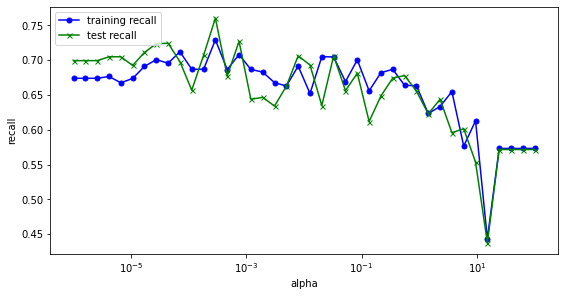

In [17]:
train_test_curve(percep2,"alpha",np.logspace(-6,2,40))

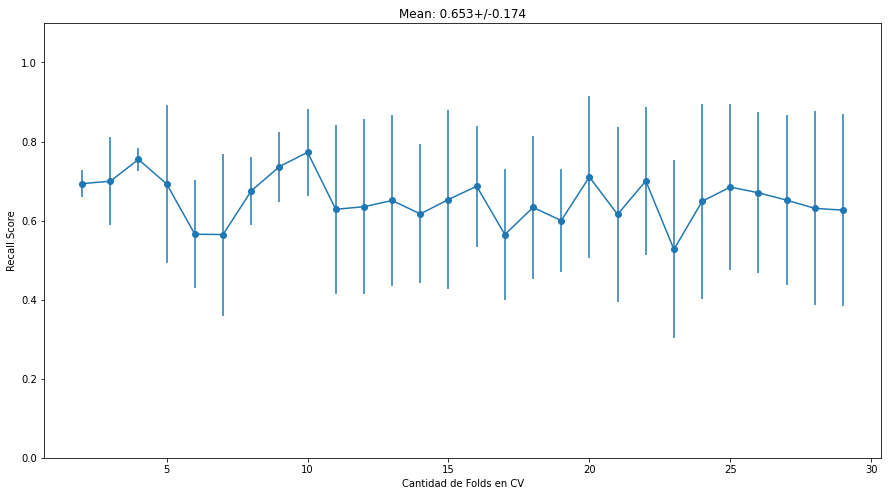

In [39]:
plt_eb(percep2,30)

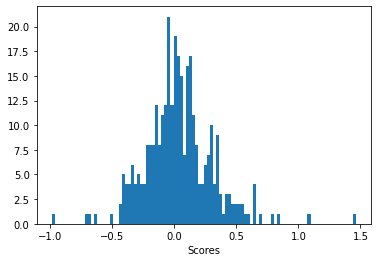

In [65]:
y_scores = cross_val_predict(percep2, feat_train, targ_train, cv=10, method="decision_function")

A = plt.hist(y_scores,100)
plt.xlabel('Scores')
plt.show()

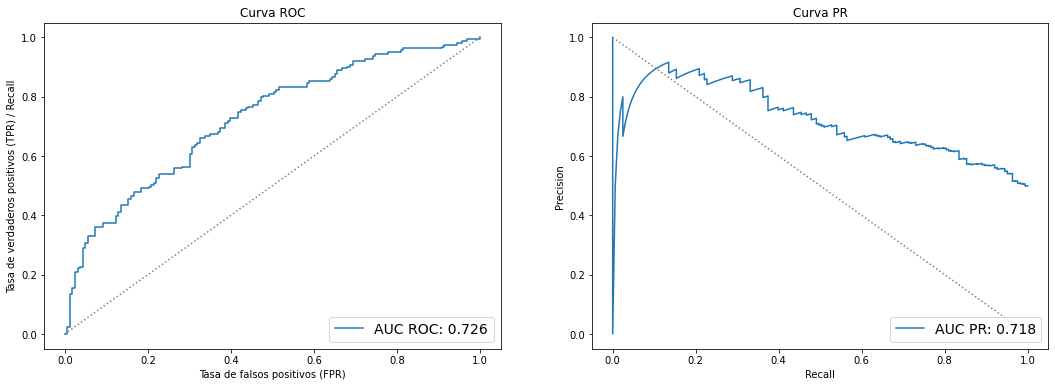

In [66]:
precisions, recalls, thresholds = precision_recall_curve(targ_train, y_scores)
fpr, tpr, thresholds = roc_curve(targ_train, y_scores)

auc_score_PR = auc(recalls, precisions)
auc_score_ROC = auc(fpr,tpr)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(122)
ax.plot(recalls,precisions, label = "AUC PR: {:.3f}".format(auc_score_PR))
ax.plot([0, 1], [1, 0], color='0.5', ls=':')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Curva PR')
ax.legend(loc='lower right', fontsize=14)

ax2 = fig.add_subplot(121)
ax2.plot(fpr, tpr,label = "AUC ROC: {:.3f}".format(auc_score_ROC))
ax2.plot([0, 1], [0, 1], color='0.5', ls=':')
ax2.set_xlabel('Tasa de falsos positivos (FPR)')
ax2.set_ylabel('Tasa de verdaderos positivos (TPR) / Recall')
ax2.set_title('Curva ROC')
ax2.legend(loc='lower right', fontsize=14)

# LOGISTIC REGRESSION

Cross Validation Score: 0.811 +/- 0.094
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       163
           1       0.80      0.81      0.80       163

    accuracy                           0.80       326
   macro avg       0.80      0.80      0.80       326
weighted avg       0.80      0.80      0.80       326



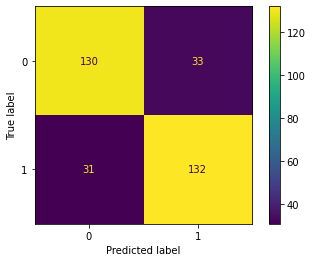

In [25]:
lr_model = LogisticRegression(dual=False, max_iter=40000,C=0.7906043210907697)
model_setup(lr_model)

In [24]:
hyperparam = {"C":np.logspace(-1,3,50)}
lr_model = LogisticRegression(dual=False, max_iter=40000,C=2)
lr_grilla = GridSearchCV(lr_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
lr_grilla.fit(feat_train,targ_train)
print(lr_grilla.best_params_)
lr_model = lr_grilla.best_estimator_

{'C': 0.7906043210907697}


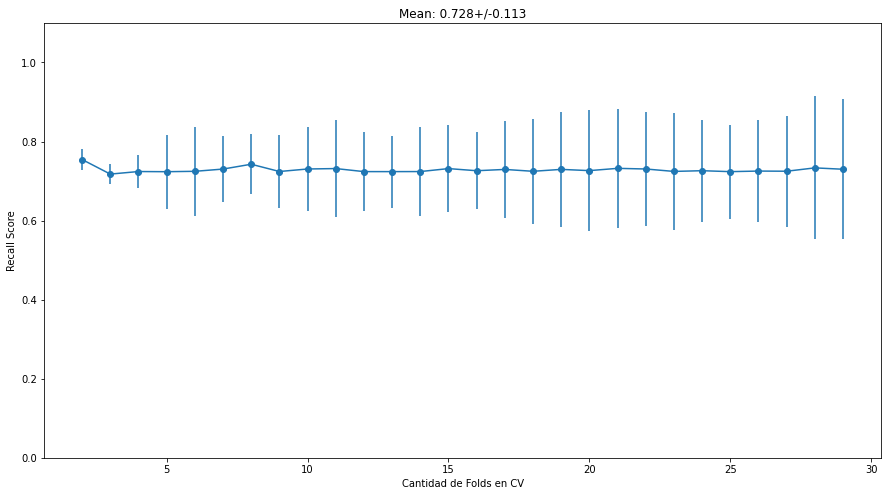

In [47]:
plt_eb(lr_model,30)

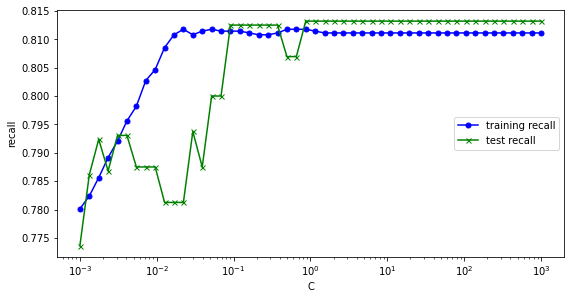

In [23]:
train_test_curve(lr_model,"C",np.logspace(-3,3,50))

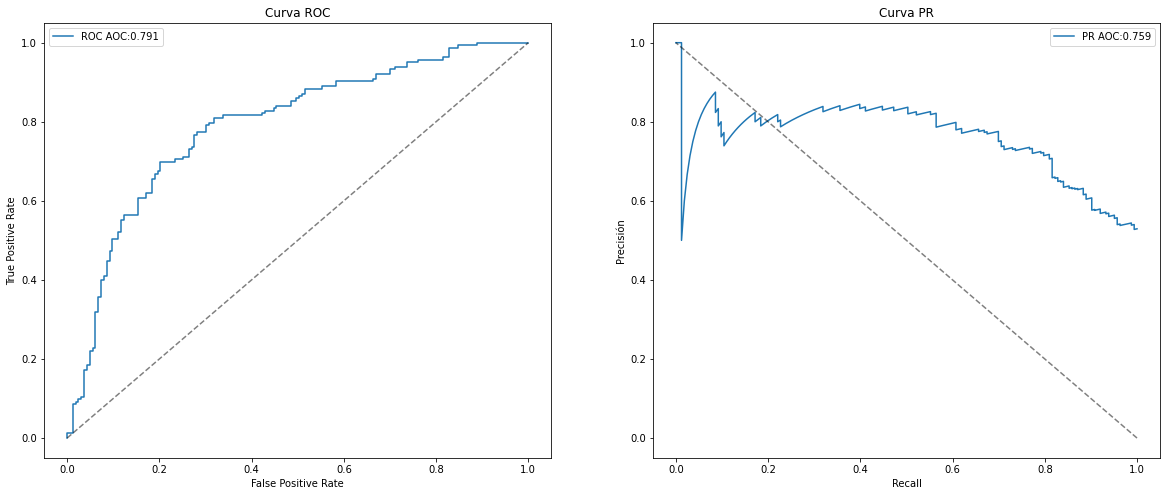

In [24]:
aoc_curves(lr_model,feat_train,targ_train)

---

# SVM

## BEST PARAMS => C = 0.85, Gamma = 0.61 -> Recall = 0.872+/-0.075

Cross Validation Score: 0.916 +/- 0.070
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       163
           1       0.82      0.91      0.87       163

    accuracy                           0.86       326
   macro avg       0.86      0.86      0.86       326
weighted avg       0.86      0.86      0.86       326



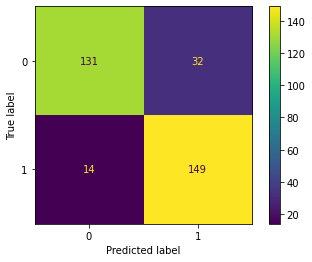

In [22]:
svm_model = SVC(probability=True,gamma=0.6210169418915616,C=0.6210169418915616)
model_setup(svm_model)

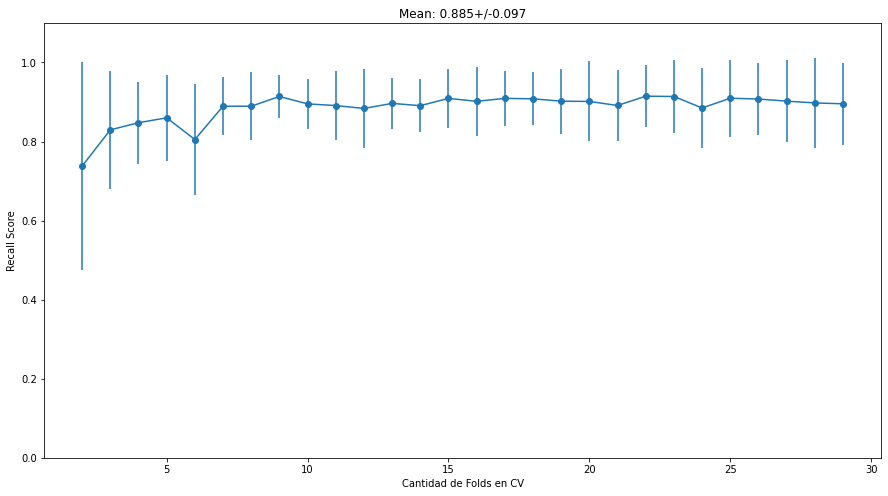

In [52]:
plt_eb(svm_model,30)

In [21]:
hyperparam = {"C":np.logspace(-2,0,30),"gamma":np.logspace(-2,2,30)}
svm_model = SVC(break_ties=True,probability=True)
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_

{'C': 0.6210169418915616, 'gamma': 0.6210169418915616}


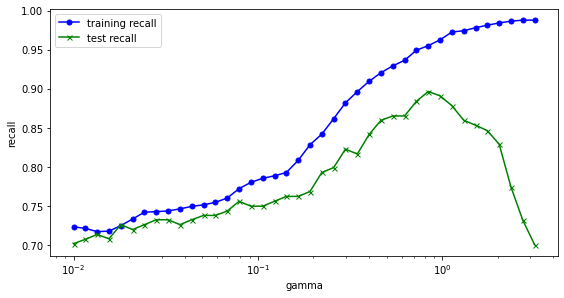

In [72]:
train_test_curve(svm_model,"gamma",np.logspace(-2,0.5,40))

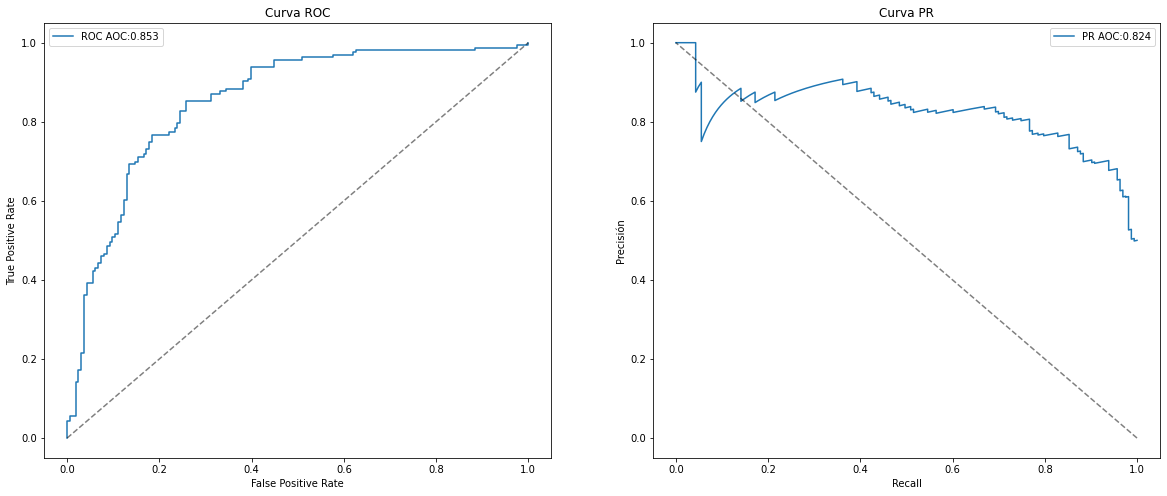

In [53]:
aoc_curves(svm_model,feat_train,targ_train)

---

# Random Forest

Cross Validation Score: 0.917 +/- 0.092
              precision    recall  f1-score   support

           0       0.92      0.83      0.87       163
           1       0.84      0.93      0.88       163

    accuracy                           0.88       326
   macro avg       0.88      0.88      0.88       326
weighted avg       0.88      0.88      0.88       326



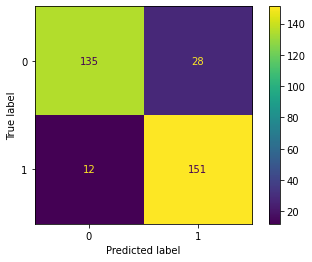

In [27]:
rf_model = RandomForestClassifier(n_estimators=100)
model_setup(rf_model)

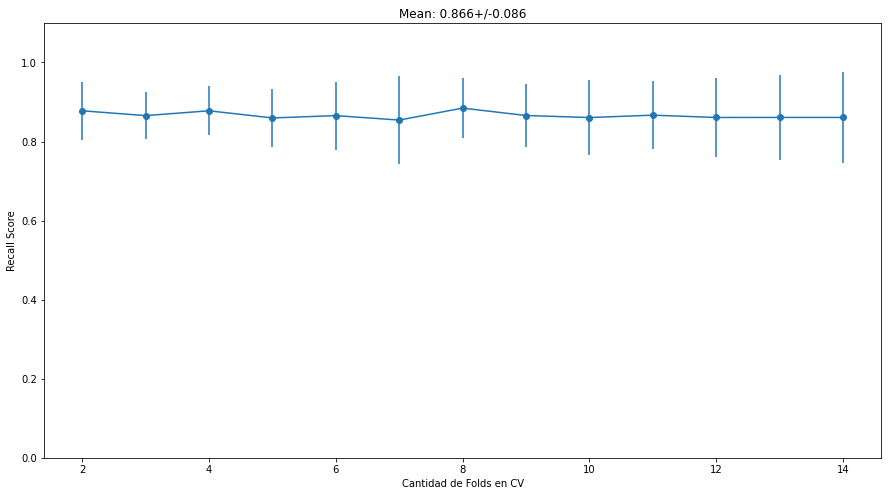

In [77]:
plt_eb(rf_model,15)

In [26]:
hyperparam = {"n_estimators":[20,50,100,200,400],"max_depth":[5,6,7,8,9,None],"min_samples_split":[2,20,30,40]}
rf_model = RandomForestClassifier(min_impurity_decrease=2e-4)
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


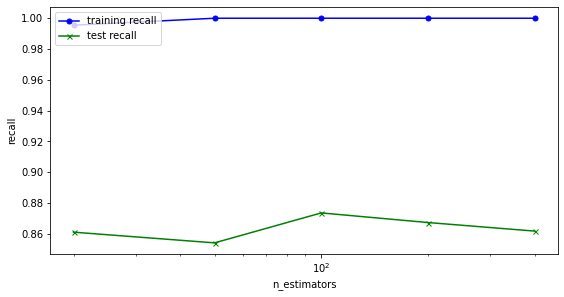

In [66]:
train_test_curve(rf_model,"n_estimators",[20,50,100,200,400])

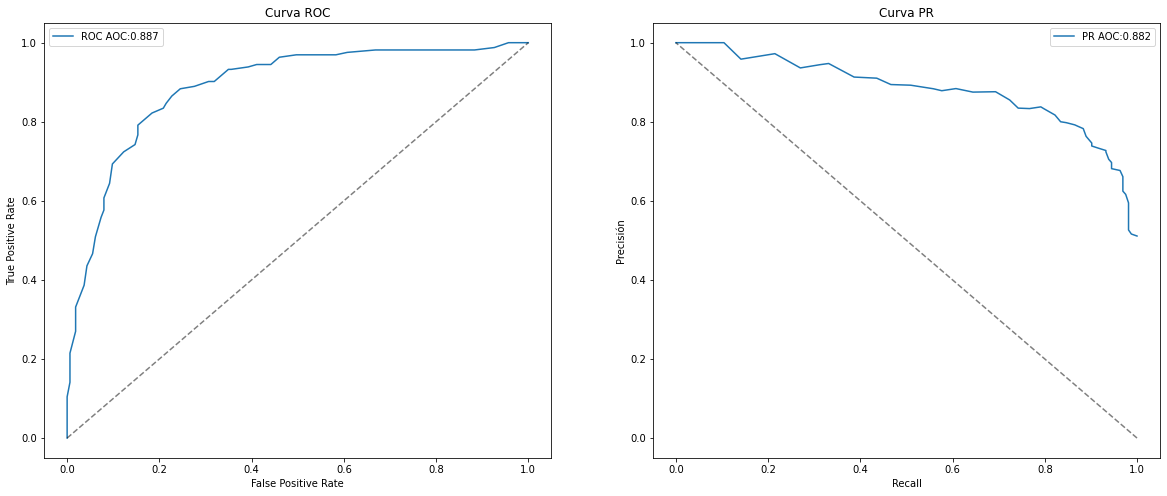

In [78]:
aoc_curves(rf_model,feat_train,targ_train)

---

# ADA BOOSTING

Cross Validation Score: 0.837 +/- 0.101
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       163
           1       0.80      0.85      0.82       163

    accuracy                           0.82       326
   macro avg       0.82      0.82      0.82       326
weighted avg       0.82      0.82      0.82       326



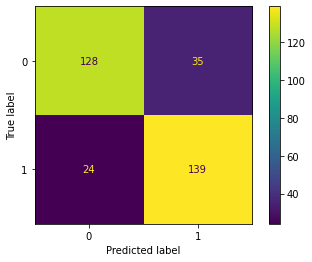

In [28]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate=2e-2)
model_setup(ada_model)

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([2.22044605e-16, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

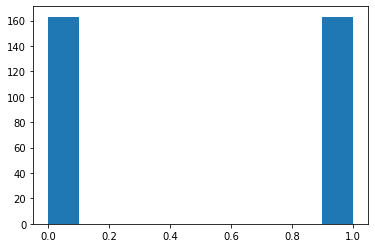

In [133]:
plt.hist(ada_model.predict_proba(feat_train)[:,1])

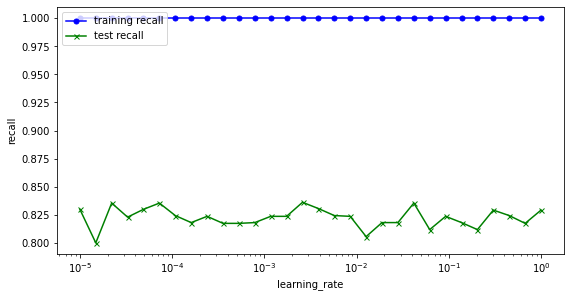

In [29]:
train_test_curve(ada_model,"learning_rate",np.logspace(-5,-0,30))

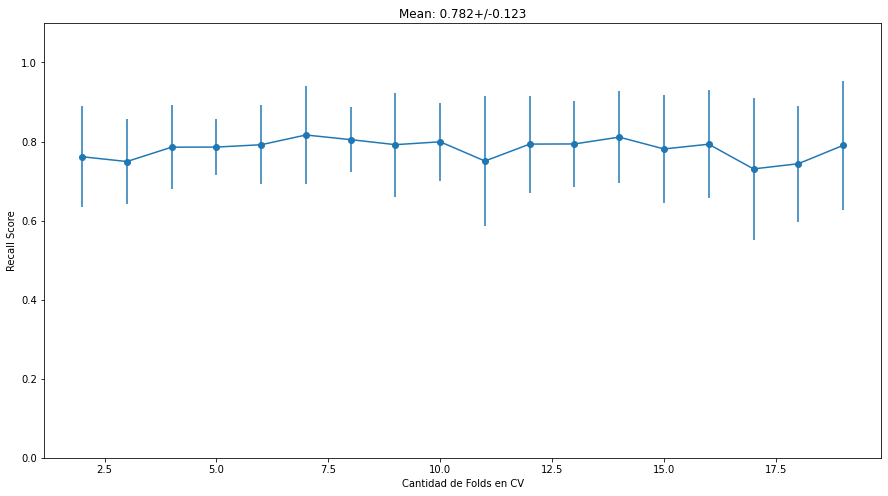

In [123]:
plt_eb(ada_model,20)

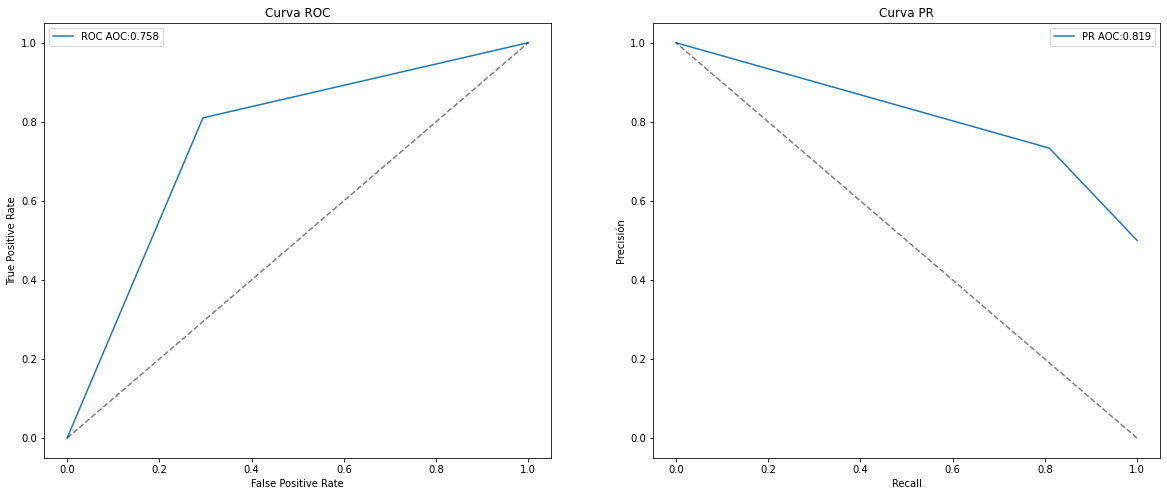

In [134]:
aoc_curves(ada_model,feat_train,targ_train)


---


# GRADIENT BOOSTING

## BEST PARAMS => n_estimators = 500, learning_rate = 0.05,objective="binary:hinge" -> Recall = 0.843+/-0.158

### Cambia levemente la metodologia, usa early stopping

In [30]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [31]:
xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=500)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric="error",early_stopping_rounds=20,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.20902	validation_1-error:0.19512
[11]	validation_0-error:0.14344	validation_1-error:0.18293
[12]	validation_0-error:0.11066	validation_1-error:0.17073
[13]	validation_0-error:0.11066	validation_1-error:0.18293
[14]	validation_0-error:0.07787	validation_1-error:0.19512
[15]	validation_0-error:0.06557	validation_1-error:0.20732
[16]	validation_0-error:0.06148	validation_1-error:0.19512
[17]	va

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       163
           1       0.83      0.90      0.86       163

    accuracy                           0.86       326
   macro avg       0.86      0.86      0.86       326
weighted avg       0.86      0.86      0.86       326



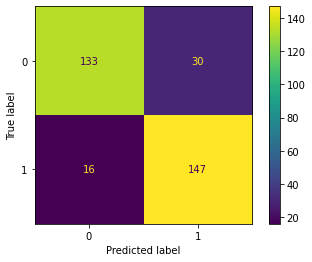

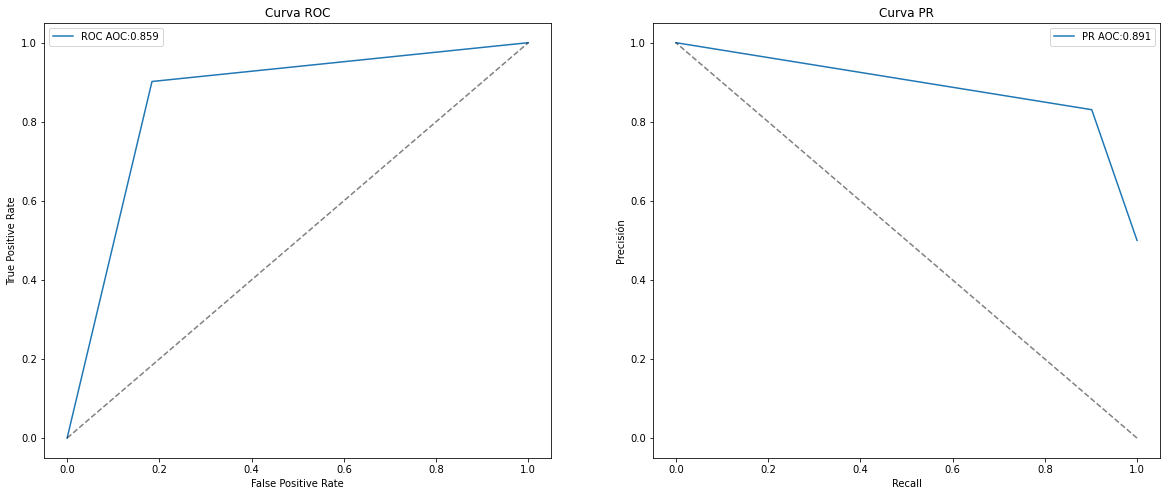

In [32]:
xgbc_predicted = cross_val_predict(xgbc_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, xgbc_predicted))
cm = confusion_matrix(targ_train, xgbc_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
aoc_curves(xgbc_model,feat_train,targ_train)

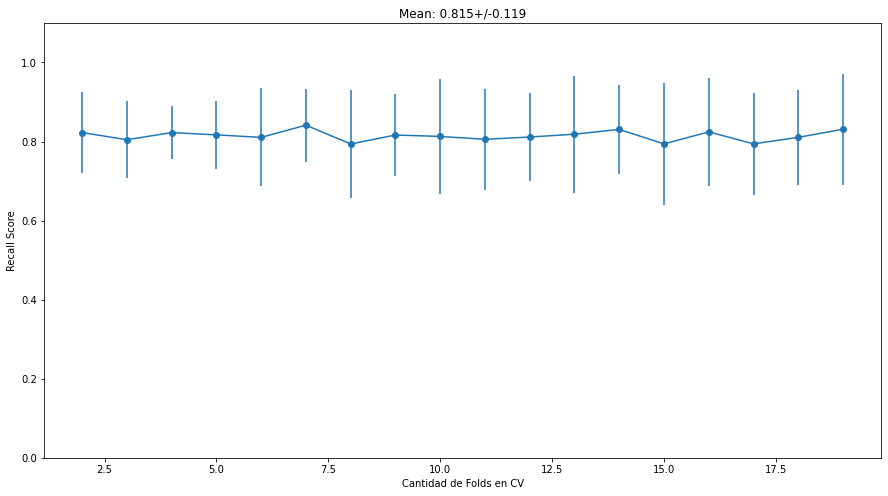

In [41]:
plt_eb(xgbc_model,20)

---

# VOTING

In [33]:
vot_hard_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svm_model)],
    voting='hard')
vot_soft_model = VotingClassifier(
    estimators=[('lr', lr_model), ('tree', rf_model), ('svc', svm_model)],
    voting='soft')

## HARD

Cross Validation Score: 0.916 +/- 0.070
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       163
           1       0.85      0.92      0.88       163

    accuracy                           0.88       326
   macro avg       0.88      0.88      0.88       326
weighted avg       0.88      0.88      0.88       326



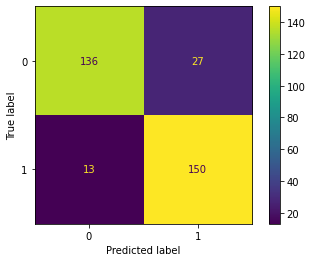

In [34]:
model_setup(vot_hard_model)

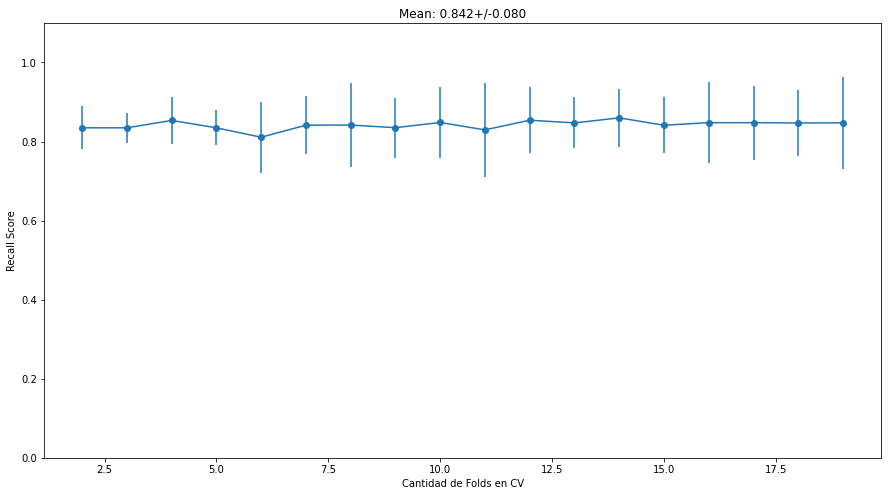

In [44]:
plt_eb(vot_hard_model,20)

## SOFT

Cross Validation Score: 0.910 +/- 0.071
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       163
           1       0.86      0.91      0.88       163

    accuracy                           0.88       326
   macro avg       0.88      0.88      0.88       326
weighted avg       0.88      0.88      0.88       326



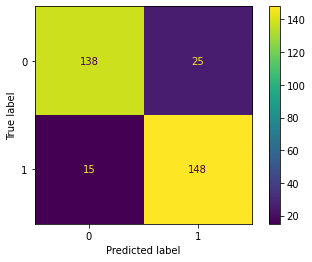

In [35]:
model_setup(vot_soft_model)

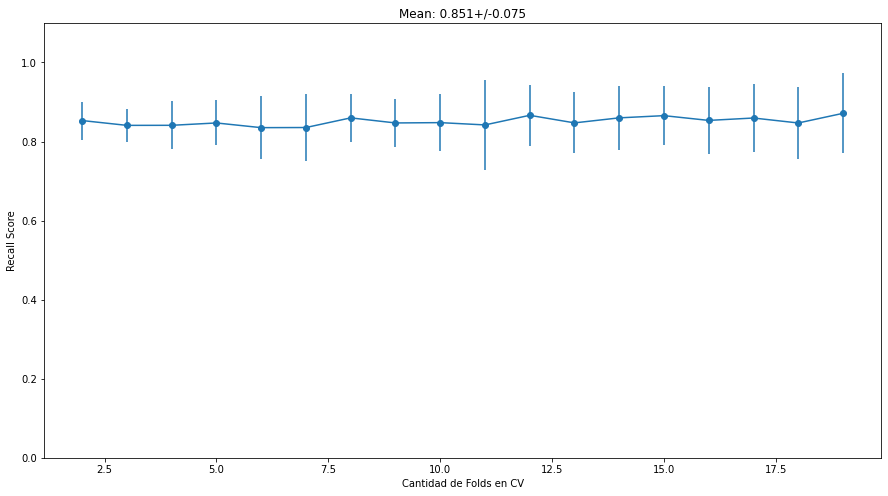

In [91]:
plt_eb(vot_soft_model,20)

---

# RED NEURONAL SIMPLE

In [36]:
keras.backend.clear_session()

In [37]:
input = keras.layers.Input(shape=[7,])
flatten = keras.layers.Flatten()(input)
hidden1 = keras.layers.Dense(100, activation="relu",kernel_initializer='he_uniform')(flatten)
dropout = keras.layers.Dropout(rate=0.2)(hidden1)
hidden2 = keras.layers.Dense(100, activation="relu",kernel_initializer='he_uniform')(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)

model = keras.models.Model(inputs=[input], outputs=[output])

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.keras.metrics.Recall()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 100)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(feat_train, targ_train, epochs=2000, batch_size=32,
                    validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)])

Epoch 1/2000
9/9 [==============================] - 1s 20ms/step - loss: 0.7385 - recall: 0.5464 - val_loss: 0.6738 - val_recall: 0.5606
Epoch 2/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.4968 - recall: 0.6392 - val_loss: 0.4775 - val_recall: 0.7727
Epoch 3/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.4360 - recall: 0.7010 - val_loss: 0.4737 - val_recall: 0.7879
Epoch 4/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.4154 - recall: 0.7010 - val_loss: 0.4882 - val_recall: 0.7727
Epoch 5/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.4006 - recall: 0.7423 - val_loss: 0.4496 - val_recall: 0.7879
Epoch 6/2000
9/9 [==============================] - 0s 3ms/step - loss: 0.3893 - recall: 0.7526 - val_loss: 0.4391 - val_recall: 0.8030
Epoch 7/2000
9/9 [==============================] - 0s 2ms/step - loss: 0.3799 - recall: 0.7320 - val_loss: 0.4860 - val_recall: 0.7879
Epoch 8/2000
9/9 [=============================

In [40]:
model.evaluate(feat_train,targ_train)

11/11 [==============================] - 0s 601us/step - loss: 0.0090 - recall: 0.9939


[0.00899574439972639, 0.9938650131225586]

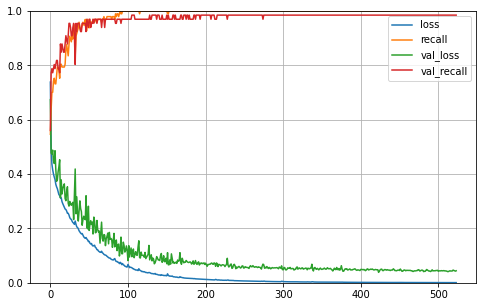

In [41]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

(array([163.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0., 161.]),
 array([1.1609266e-17, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

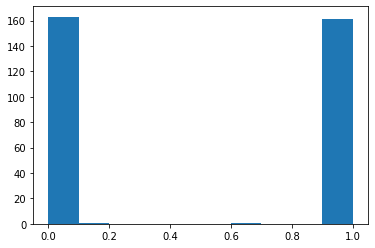

In [42]:
plt.hist(model.predict(feat_train))

(array([163.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 163.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

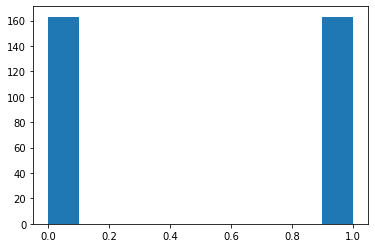

In [53]:
plt.hist(targ_train)

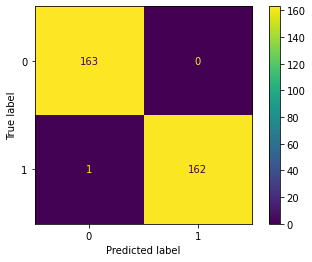

In [43]:
cm = confusion_matrix(targ_train, model.predict(feat_train)>0.5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()